In [2]:
import os
import numpy as np
import cv2
def depth2PointCloud(
    depth_map, fx, fy, cx, cy, depth_scale=1.0
):
    """
    Converts a depth map to a point cloud.

    Args:
        depth_map (numpy.ndarray): The depth map as a 2D numpy array.
        fx (float): The focal length in the x-axis.
        fy (float): The focal length in the y-axis.
        cx (float): The principal point in the x-axis.
        cy (float): The principal point in the y-axis.
        min_depth (float, optional): Minimum valid depth value (default: 0.2 meters).
        max_depth (float, optional): Maximum valid depth value (default: 3.0 meters).
        depth_scale (float, optional): Scaling factor to convert depth values (default: 1000.0).

    Returns:
        numpy.ndarray: A point cloud represented as a numpy array of shape (N, 3) where N is the number of points.

    Note:
        This function applies median filtering and removes outliers from the depth map
        before converting it to a point cloud.

    Example:
        depth_map = load_depth_map()
        fx = 500.0
        fy = 500.0
        cx = 320.0
        cy = 240.0
        point_cloud = depth2PointCloud(depth_map, fx, fy, cx, cy)
    """
    rows, cols = depth_map.shape

    # Apply the median filter to the depth image
    depth = cv2.medianBlur(depth_map, ksize=3)
    depth = depth.astype(np.float32) / depth_scale

    # Create a mesh grid for the depth map
    mesh_x, mesh_y = np.meshgrid(np.arange(cols), np.arange(rows))
    f = (fx + fy) / 2

    # Calculate 3D coordinates (X, Y, Z) from depth values
    x =\
    (mesh_x - cx) * depth / f
    y = (mesh_y - cy) * depth / f
    z = depth

    point_cloud = np.stack((x, y, z), axis=-1)
    # point_cloud = np.delete(point_cloud, idx, axis=0)

    return point_cloud

Run the rerun.io app on your host computer or the raspberry pi itself and note the port number rerun opens (printed in terminal). Then run the following to instantiate the logger:

In [4]:
import rerun as rr

host_address = "10.42.0.1" # The IP address of the host computer. If running on the Pi iteself, replace with 127.0.0.1
host_port = 9876           # The TCP port opened by the rerun.io app. If you run the app in terminal, this port number will be printed out.
rr.init('app', spawn=False)
rr.connect(f'{host_address}:{host_port}')

Now use the Arducam Python SDK to communicate with the camera:

In [5]:
import sys
sys.path.append('/usr/local/lib/python3.11/dist-packages/')
import ArducamDepthCamera.ArducamDepthCamera as ac
cam = ac.ArducamCamera()
cam.open(ac.TOFConnect.CSI,0)

<TOFErrorCode.ArducamSuccess: 0>

Set the near or far mode. For near, set to 2000 and for Far set to 4000. 

**ToDo**: This mode change is not working for near mode. Set it to 4000 for now

In [6]:
cam.setControl(ac.TOFControl.RANGE, 4000)


<TOFErrorCode.ArducamSuccess: 0>

In [7]:
cam.start(ac.TOFOutput.DEPTH)

<TOFErrorCode.ArducamSuccess: 0>

If the output of all above was successful, you can plot the output depth image, confidence map, and grayscale image from the camera:

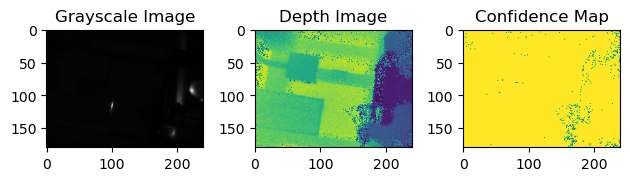

In [14]:
import matplotlib.pyplot as plt
CONFIDENCE = 0

frame = cam.requestFrame(200)
depth = frame.getDepthData().copy()
confidence = frame.getConfidenceData().copy()
image = frame.getAmplitudeData().copy()
cam.releaseFrame(frame)
fig, ax = plt.subplots(1,3)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[1].imshow(depth)
ax[1].set_title('Depth Image')
ax[2].imshow(confidence>CONFIDENCE)
ax[2].set_title('Confidence Map')
plt.tight_layout()

Finally, continuesly capture frames, compute the corresponding pointclouds, and send them to rerun for visualization. Play with the `CONFIDENCE` parameter to filter out noisy points.

In [9]:
from math import tan
import numpy as np
info = cam.getCameraInfo()
max_width = info.width
max_height = info.height
fx = max_width / (2 * tan(0.5 * 3.1415 * 64.3 / 180))
fy = max_height / (2 * tan(0.5 * 3.1415 * 50.4 / 180))
cx = max_width / 2
cy = max_height / 2

In [11]:
import time
timeout = 10
start = time.time()
while time.time()-start < timeout:
    frame = cam.requestFrame(200)
    depth = frame.getDepthData().copy()
    confidence = frame.getConfidenceData().copy()
    image = frame.getAmplitudeData().copy()
    cam.releaseFrame(frame)
    pcd = depth2PointCloud(depth, fx, fy, cx, cy, 1000)
    pcd = pcd[confidence>CONFIDENCE]
    radii = np.ones((pcd.shape[0],1))*0.001
    rr.log('pcd', rr.Points3D(pcd, radii=radii))
    rr.set_time_seconds('tof_time', 0)
    time.sleep(0.1)

In [23]:
cam.close()

<TOFErrorCode.ArducamSuccess: 0>